# _FOR HERSHEY ONLY_ #

# Eye Tracking Overview

Subjects wore eye-tracking goggles while they shopped, and the data tells us:
- a row for every "glance" the eyeball made
- attributes about the product (color/price/type) that the eyeball glanced at
- the spatial x,y,z coordinates of the glance
- the timing of the glance, which is used to determine whether it was a __fixation__ or not

##### OBJECTIVE: Predict the likelihood of a glance to be a fixation. What factors matter? The goal is insights.

This model is intended to yield insights, which may help product placement, packaging, and pricing decisions.

![Heat maps reveal packs that stand out](fig1.jpg "Source: Package InSight via The Packaging School")

_______________________
##### Imports and directory setup

In [1]:
# imports
from pathlib import Path
import os
import numpy as np
import pandas as pd
import pickle
import datarobot as dr
import datetime

# display options for notebooks only
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 199)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# set path directories
curr_dir = Path(os.getcwd())
data_dir = Path(curr_dir.parents[0] / 'data/')
artifacts_dir = Path(curr_dir.parents[0] / 'artifacts/')

#### Helper Functions
These functions will be used later, throughout this notebook. Simply run this cell so that the functions exist later.

In [2]:
# This function reduces the memory footprint of a dataframe
# Makes things run faster
def reduce_mem_usage(df, verbose=True):
    import numpy as np
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Importing Data

In [3]:
ORIGINAL_DATA_FILENAME = 'DR Merged Fixation-Dwell-Purchase.csv'  # original data
TARGET_VARIABLE_NAME   = 'Fixation' # what are we predicting?
OUTPUT_DATA_FILENAME = 'fixation_training.csv.gz' # (optional) do you want to export the training data as a file?

In [4]:
indata = pd.read_csv(Path(data_dir) / ORIGINAL_DATA_FILENAME)
indata = reduce_mem_usage(indata)

Mem. usage decreased to 29.94 MB (56.8% reduction)


In [9]:
cleandata = indata[['Respondent ID','Product Code','Aisle','Avg Z', 'Avg Y','Avg X','Price','Color','Strikezone',
                    'Categorized Group','Brand','Overarching Category Exp','WMT','Fixation'
                   ]].copy()
cleandata['Price'] = np.round(cleandata['Price'], 2)
cleandata.Fixation.replace(('Yes', 'No'), (1, 0), inplace=True)
cleandata.Strikezone.replace(('Strikezone', 'No'), ('Yes', 'No'), inplace=True)
cleandata['Color'] = cleandata['Color'].str.replace('/','_')
cleandata['Color'].fillna('Missing', inplace=True)

# Would we need to scale the coordinates to the same system?
# assuming no, but here is where you would want to do that
# from sklearn.preprocessing import MinMaxScaler

cleandata.head(6)

,Respondent ID,Product Code,Aisle,Avg Z,Avg Y,Avg X,Price,Color,Strikezone,Categorized Group,Brand,Overarching Category Exp,WMT,Fixation
0,1005,1,2,2.9375,1.741211,-7.925781,9.617188,Gold,No,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,0
1,3597,1,2,2.9375,1.741211,-7.925781,9.617188,Gold,No,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,0
2,4049,1,2,2.9375,1.741211,-7.925781,9.617188,Gold,No,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,0
3,4057,1,2,3.0000,1.939453,-7.914062,9.617188,Gold,No,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,1
4,4108,1,2,2.9375,1.741211,-7.925781,9.617188,Gold,No,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,0
5,4309,1,2,2.9375,1.741211,-7.925781,9.617188,Gold,No,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,0


_____________________
#### Plot the points for each glance
If we plot all of the data on a scatter plot, and color every single product differently, then in theory we should be able to visualize the product layout.

In [11]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
sns.set_palette("bright")  #https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/

g = sns.FacetGrid(cleandata[cleandata['Product Code']<9999], col="Aisle", hue="Product Code")
g.map(plt.scatter, "Avg Z", "Avg Y", alpha=.9)

# only the Lindt brand 
#g = sns.FacetGrid(cleandata[cleandata['Brand']<'Lindt'], col="Aisle", hue="Product Code")
#g.map(plt.scatter, "Avg Z", "Avg Y", alpha=.9)

That's so ugly and difficult to see, because there is a point for every single glance from the eyeball. Let's find a center point for every product in every aisle, and only plot a single point. 

#### Average the glances for each product to find the "center"
Instead of plotting every point, let's calculate the center for each product. Then we can reduce the dataset to 1 row for every Aisle-Product combination.
This might make it easier to visualize, as well as help us with some feature engineering.

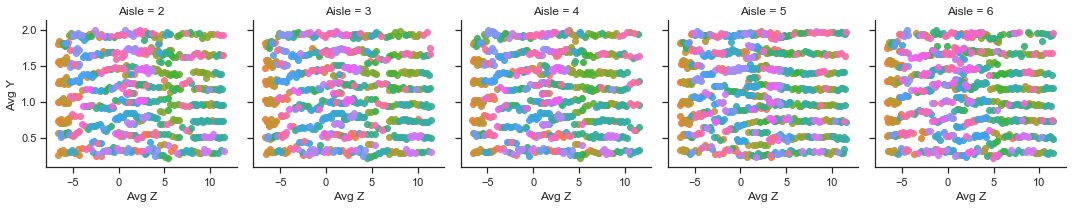

In [12]:
# there was an error with the coords where Fixation=No
# technically this fix only works if 100% of Product-Aisles have a =Yes record
# only a small handful donot, so this will suffice for a first draft
only_fixation = cleandata[cleandata['Fixation']==1].copy()

pointdata = only_fixation[['Aisle','Product Code','Avg Z','Avg Y','Avg X']].groupby(['Aisle','Product Code'], as_index=False)['Avg Z','Avg Y','Avg X'].agg('mean')

g = sns.FacetGrid(pointdata, col="Aisle", hue="Product Code")
g.map(plt.scatter, "Avg Z", "Avg Y", alpha=.9)

That's a little better!
________________________

Now, we can refer to the locations as the singular point. While we're at it, let's also rename the coordinates to x,y because it's easier to think about it that way.

NOTE: all x,y coords for each Aisle-Product combination are now the same.

In [13]:
cleandata.set_index(['Aisle','Product Code'])
pointdata.set_index(['Aisle','Product Code'])
cleanpointdata = pd.merge(cleandata.drop(columns=['Avg Z','Avg Y','Avg X']),pointdata, on=['Aisle','Product Code']).copy()
cleanpointdata.drop(columns=['Strikezone','Fixation','Respondent ID'], inplace=True)
cleanpointdata.drop_duplicates(inplace=True)
cleanpointdata.rename(columns={'Avg Z': 'x', 'Avg Y': 'y', 'Avg X': 'z'}, inplace=True)
cleanpointdata = cleanpointdata.reset_index(drop=True)

In [15]:
cleanpointdata.head(7)

,Product Code,Aisle,Price,Color,Categorized Group,Brand,Overarching Category Exp,WMT,x,y,z
0,1,2,9.617188,Gold,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,3.023438,1.930664,-7.914062
1,1,3,9.617188,Gold,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,3.029297,1.928711,-7.914062
2,1,4,9.617188,Gold,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,3.042969,1.934570,-7.914062
3,1,5,9.617188,Gold,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,3.406250,1.692383,-7.925781
4,1,6,9.617188,Gold,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,2.189453,1.693359,-7.910156
5,10,2,2.779297,Brown,PREMIUM BAR,Lindt,PREMIUM,LINDT EXCELLENCE 95% DARK CHOCOLATE BAR,1.977539,1.234375,-7.929688
6,10,3,2.779297,Brown,PREMIUM BAR,Lindt,PREMIUM,LINDT EXCELLENCE 95% DARK CHOCOLATE BAR,1.924805,1.227539,-7.859375


### Reviewing the "Strikezone"


In [13]:
cleandata.groupby(['Strikezone']).agg({'Fixation': ['mean','count']})

Fixation        
                mean   count
Strikezone                  
No          0.363653   58520
Yes         0.265293  100817

This is interesting, that _Fixation is more likely to occur OUTSIDE of the Strikezone_, rather than inside of it. This is backward from what our intuition says. 

Then, what is the advantage of the strikezone? Well, the number of glances seems to be concentrated inside the Strikezone.


![Hypothesis](fig2.png "Strikezone")

Ths is because the human eye rests in this range. So, in one sense, the glances _outside_ the strike zone are of higher quality because there is a purpose for the eyeball to leave it's comfort zone. Consider the possibility that _the human detects the object __before__ moving eyeball out of the strikezone._ In other words, peripheral vision.
Does this imply that these eye-tracking studies may be missing data which could be useful? More importantly, how can we measure data that the eyeball is not actually looking at yet?

Our best option is to __give our data peripheral vision, as well__. Instead of learning that the color Yellow is good for fixating, perhaps we consider if it's just the color yellow, or the fact that yellow is next to other colors that make it stand out. Or put differntly - is it the price that makes someone fixate? Or is it the price in relation to the price adjacent to it.

You may be thinking - can we build a model to predict the *number* of fixations, instead of the the probability of a glance to be a fixation? One could argue that we shouldn't care about the fixation:glance ratio, but instead just care about the pure volume of fixations that a product receives. This is a good point. We will also use this approach as well, and compare the insights.

### Accounting for Adjacency with Feature Engineering
Earlier, we estimated the location of each product by averaging the x,y,z coordinates for each Aisle-Product combination. Now, we can use spatial functions to extract adjacency information.

For each product, query neighbors within a specified distance `r`.
The hyperparameters `r` is tricky to tune, because there is no implied unit like inches or centimeters to work with. However with some trial and error we arrived at several buffers of varying distances:
- `closest`: some do not even have neighbors, some have 1 or 2
- `close`: most have at least 3 or 4 neighbors, some have 10
- `far`: everyone has many neighbors, an average of 10-20 neighbors
- `section`: a very large section which contains around 50 neighbors each

In [14]:
from scipy.spatial import cKDTree

In [15]:
def list_magic(df, newcol, nearlist, itemlist):

    closest_items = []
    for i, neighbors_list in enumerate(nearlist):
        remapped = []
        for row_index in neighbors_list:
            if i != row_index:
                remapped.append(itemlist[row_index])
        closest_items.append(remapped)
    
    df[newcol] = pd.Series(closest_items, index=df.index)
    
    return df
    
def find_neighbors(df):
    aisles = list(df['Aisle'].unique())

    counter = 1
    for a in aisles:
        
        result = df[df.Aisle==a].copy()
        mytree = cKDTree(result[['x', 'y', 'z']].values, leafsize=50)
        
        closest = mytree.query_ball_tree(mytree, r=0.25, p=1, eps=0)
        close = mytree.query_ball_tree(mytree, r=0.5, p=1, eps=0)
        far = mytree.query_ball_tree(mytree, r=0.8, p=1, eps=0)
        section = mytree.query_ball_tree(mytree, r=1, p=1, eps=0)
        
        prods = result['Product Code'].tolist()
        colors = result['Color'].tolist()
        prices = result['Price'].tolist() 
        groups = result['Categorized Group'].tolist()

        result = list_magic(result, 'closest_colors', closest, colors)
        result = list_magic(result, 'close_colors', close, colors)
        result = list_magic(result, 'far_colors', far, colors)
        result = list_magic(result, 'section_colors', section, colors)
        
        result = list_magic(result, 'closest_prices', closest, prices)
        result = list_magic(result, 'close_prices', close, prices)
        result = list_magic(result, 'far_prices', far, prices)
        result = list_magic(result, 'section_prices', section, prices)

        result = list_magic(result, 'closest_groups', closest, groups)
        result = list_magic(result, 'close_groups', close, groups)
        result = list_magic(result, 'far_groups', far, groups)
        result = list_magic(result, 'section_groups', section, groups)
        
        if counter == 1:
            final = result.copy()
        else:
            final = final.append(result)
        
        counter += 1
        
    return final

In [16]:
merged_with_neighbors = find_neighbors(cleanpointdata)
merged_with_neighbors.drop(columns=['x','y','z','Color','Price','Categorized Group','Brand','Overarching Category Exp','WMT'], inplace=True)
mergedpointdata = pd.merge(cleanpointdata,merged_with_neighbors, on=['Aisle','Product Code'])

In [17]:
mergedpointdata.sample(n=2)

,Product Code,Aisle,Price,Color,Categorized Group,Brand,Overarching Category Exp,WMT,x,y,z,closest_colors,close_colors,far_colors,section_colors,closest_prices,close_prices,far_prices,section_prices,closest_groups,close_groups,far_groups,section_groups
1653,437,5,6.980469,White,CPC FAMILY,Dove,CANDY DISH,DOVE DC PROMISES SUP 15.8OZ,5.2500,1.423828,-7.914062,"[Orange, White, White]","[Red, Orange, Orange, Orange, White, White, Wh...","[Red, Orange, Orange, Orange, Orange, Orange, ...","[Red, Orange, Orange, Orange, Orange, Orange, ...","[2.98046875, 6.98046875, 6.98046875]","[5.28125, 5.28125, 2.98046875, 5.28125, 8.9765...","[5.28125, 9.9375, 5.28125, 5.28125, 3.48046875...","[5.28125, 2.779296875, 9.9375, 5.28125, 5.2812...","[OTG CHOC HTM POUCH MED, CPC FAMILY, CPC FAMILY]","[OTG CHOC HTM POUCH FAMILY, CPC FAMILY, OTG CH...","[OTG CHOC HTM POUCH FAMILY, CPC PARTY, CPC FAM...","[OTG CHOC HTM POUCH FAMILY, CPC SS MED, CPC PA..."
1755,458,5,1.879883,White,OTG XL BAR,Dove,ON THE GO,DOVE MILK CHOCOLATE TABLET BAR,4.5625,1.203125,-7.914062,"[White, White, White]","[White, White, White, White, White, White, Whi...","[Yellow, Yellow, Purple, Brown, Red, White, Ta...","[Blue, Aqua, Yellow, Yellow, Yellow, Purple, P...","[3.869140625, 1.8798828125, 1.8798828125]","[3.869140625, 8.9765625, 3.98046875, 3.9804687...","[2.98046875, 2.98046875, 1.98046875, 2.9804687...","[5.98046875, 5.98046875, 2.98046875, 8.578125,...","[OTG FRUIT/NUT HTM POUCH, OTG XL BAR, OTG XL BAR]","[OTG FRUIT/NUT HTM POUCH, OTG FRUIT/NUT HTM PO...","[OTG FRUIT/NUT HTM POUCH, OTG FRUIT/NUT HTM PO...","[PREMIUM POUCH, PREMIUM POUCH, OTG FRUIT/NUT H..."


____________________
Now let's create some additional variables which compares the item to the surrounding items:
* `rng_of_prices_{vicinity}` this is the ratio of price to surrounding items in the vicinity
* `ratio_price_to_min_{vicinity}` this is the product price divided by the minimum price in the vicinity
* `ratio_price_to_max_{vicinity}` this is the product price divided by the minimum price in the vicinity
* `ratio_price_to_avg_{vicinity}` this is the product price divided by the minimum price in the vicinity
* `is_higest_{vicinity}` and `is_lowest_{vicinity}` this is a binary flag for if the product is the most expensive or most cheap in the vicinity

In [18]:
expanded_prices = mergedpointdata.copy()
for l in ['closest','close','far','section']:
    
    expanded_prices['__max_of_prices_' + l] = expanded_prices[l + '_prices'].apply(lambda row: np.nan if len(row) <= 2 else max(row))
    expanded_prices['__min_of_prices_' + l] = expanded_prices[l + '_prices'].apply(lambda row: np.nan if len(row) <= 2 else min(row))    
    expanded_prices['__avg_of_prices_' + l] = expanded_prices[l + '_prices'].apply(lambda row: np.nan if len(row) <= 2 else np.median(row))        
    
    expanded_prices['rng_of_prices_' + l] = expanded_prices['__max_of_prices_' + l] - expanded_prices['__min_of_prices_' + l]
    expanded_prices['ratio_price_to_min_' + l] = expanded_prices['Price'] / expanded_prices['__min_of_prices_' + l]
    expanded_prices['ratio_price_to_avg_' + l] = expanded_prices['Price'] / expanded_prices['__avg_of_prices_' + l]
    expanded_prices['ratio_price_to_max_' + l] = expanded_prices['Price'] / expanded_prices['__max_of_prices_' + l]
    
    expanded_prices['is_highest_' + l] = (expanded_prices['Price'] >= expanded_prices['__max_of_prices_' + l]).astype(int)
    expanded_prices['is_lowest_' + l] = (expanded_prices['Price'] <= expanded_prices['__min_of_prices_' + l]).astype(int)
    
    expanded_prices = expanded_prices.loc[:,~expanded_prices.columns.str.startswith('__')]


In [19]:
expanded_prices.drop(columns=['closest_prices','close_prices','far_prices','section_prices','closest_groups','close_groups','far_groups','section_groups','closest_colors','close_colors'
                              ,'far_colors','section_colors','x','y','z','Price','Color','Categorized Group','Brand','Overarching Category Exp','WMT'], inplace=True)
expanded_prices.sample(n=2)

,Product Code,Aisle,rng_of_prices_closest,ratio_price_to_min_closest,ratio_price_to_avg_closest,ratio_price_to_max_closest,is_highest_closest,is_lowest_closest,rng_of_prices_close,ratio_price_to_min_close,ratio_price_to_avg_close,ratio_price_to_max_close,is_highest_close,is_lowest_close,rng_of_prices_far,ratio_price_to_min_far,ratio_price_to_avg_far,ratio_price_to_max_far,is_highest_far,is_lowest_far,rng_of_prices_section,ratio_price_to_min_section,ratio_price_to_avg_section,ratio_price_to_max_section,is_highest_section,is_lowest_section
89,116,3,NaN,NaN,NaN,NaN,0,0,3.740234,1.0,0.751638,0.374592,0,1,5.300781,1.333721,0.90315,0.320929,0,0,7.296875,1.333721,0.751638,0.249565,0,0
96,117,5,3.740234,1.0,1.0,0.374592,0,1,4.439453,1.0,0.903150,0.335380,0,1,5.558594,1.333721,0.90315,0.309498,0,0,7.960938,1.333721,0.903150,0.232374,0,0


____________________
Next, we can calculate the distance to the nearest items of the same color:
- `dist_to_same_color` - distance to the nearest color from all of the other products

In [20]:
def closest_color(df):
    aisles = list(df['Aisle'].unique())
    counter=1
    
    for a in aisles:

        single_aisle = df[df.Aisle==a].copy().reset_index(drop=True)
        
        color_list = list(single_aisle['Color'].unique())
        
        single_aisle_tree = cKDTree(single_aisle[['x', 'y', 'z']].values, leafsize=5)

        for color in color_list:
            #print(color)
            single_color = single_aisle[single_aisle.Color==color].copy()
            if single_color.size == 0:
                continue

            single_color_tree = cKDTree(single_color[['x', 'y', 'z']].values, leafsize=5)

            dists = single_aisle_tree.sparse_distance_matrix(single_color_tree, max_distance=9999, p=1).todense()

            dists[dists<=0] = 99999
            mindists = dists.min(axis=1)
            df_mindists = pd.DataFrame(mindists)
            colname = 'dist2color_' + color
            df_mindists.columns=[colname]

            single_aisle = pd.concat([single_aisle, df_mindists], axis=1)

            single_aisle.reset_index(drop=True).set_index(['Product Code','Aisle'])
    
        if counter==1:
            final = single_aisle.copy()
        else:
            final = final.append(single_aisle, sort=False)
        counter+=1
    
    return final

In [21]:
expanded_colors = closest_color(cleanpointdata)
expanded_colors.drop(columns=['x','y','z','Price','Categorized Group','Brand','Overarching Category Exp','WMT'], inplace=True)

# collapse distance matrix to closest to SAME color
mask = expanded_colors['Color'].values == expanded_colors.columns[3:].str.extract('_(.*)$').values
expanded_colors['dist_to_same_color'] = expanded_colors.iloc[:,3:].where(mask.T).bfill(1).iloc[:,0]
dist_to_color = expanded_colors[['Product Code','Aisle','dist_to_same_color']]
dist_to_color.head(2)

,Product Code,Aisle,dist_to_same_color
0,1,2,0.186523
1,10,2,0.324219


___________________________
Next, lets create counter columns for each color in the vicinity of the product, and then calculate the ratio of the vicinity which is the same color. The final column's we'll keep are:
- `dominant_color_{vicinity}` - the single most dominant color in the vicinity. With ties, we do alphabetically (this could probably be done better in the future)
- `color_vs_dominant_{vicinity}` - we create a categorical variable by concatenating the color and the dominant color. This not done because we think it'll help the model, but because this could provide some good insights.
- `same_color_ratio_{vicinity}` - This is a percentage of the vicinity that is the same color as the product

In [22]:
from collections import Counter

vicinitydata = mergedpointdata[['Product Code','Aisle','Color','closest_colors','close_colors','far_colors','section_colors']].copy()
list_of_vicinities = ['closest_colors','close_colors','far_colors','section_colors']

colors = vicinitydata['Color'].unique().tolist()

# outer loop through all of the vicinities
for v in list_of_vicinities:
    drop_later_list = []
    
    # find the most common
    vicinitydata['dominant_color_' + v.split("_")[0]] = vicinitydata[v].apply(lambda x: Counter(", ".join(x).split(", ")).most_common(1)[0][0])
    
    # lists into strings
    vicinitydata[v] = vicinitydata[v].apply(', '.join)
    vicinitydata['dominant_color_' + v.split("_")[0]] = vicinitydata['dominant_color_' + v.split("_")[0]].apply(''.join)
    
    # count items in string (used to be a list)
    vicinitydata['item_count_' + v.split("_")[0]] = vicinitydata[v].str.split().str.len()
    
    # identify combination of color vs the dominant color   COLOR|DOMINANT
    vicinitydata['color_vs_dominant_' + v.split("_")[0]] = vicinitydata['Color'].astype(str) + "|" + vicinitydata['dominant_color_' + v.split("_")[0]].astype(str)

    # loop through all colors and calculate the same color ratio
    for c in colors:
        temp = v.split("_")[0] + '__' + c
        drop_later_list.append(temp)
        vicinitydata[temp] = vicinitydata[v].str.count(c)
        mask = vicinitydata['Color'].values == vicinitydata.columns[1:].str.extract('__(.*)$').values
        vicinitydata['same_color_' + v.split("_")[0]] = vicinitydata.iloc[:,1:].where(mask.T).bfill(1).iloc[:,0]
        
        drop_later_list.append('same_color_' + v.split("_")[0])      
    drop_later_list.append('item_count_' + v.split("_")[0])
    
    vicinitydata['same_color_ratio_' + v.split("_")[0]] = vicinitydata['same_color_' + v.split("_")[0]] / (vicinitydata['item_count_' + v.split("_")[0]] + 1e-6)
    
    vicinitydata.drop(columns=drop_later_list, inplace=True)
vicinitydata.drop(columns=list_of_vicinities + ['Color'], inplace=True)

vicinitydata.head(2)

,Product Code,Aisle,dominant_color_closest,color_vs_dominant_closest,same_color_ratio_closest,dominant_color_close,color_vs_dominant_close,same_color_ratio_close,dominant_color_far,color_vs_dominant_far,same_color_ratio_far,dominant_color_section,color_vs_dominant_section,same_color_ratio_section
0,1,2,Gold,Gold|Gold,0.333333,Red,Gold|Red,0.250000,Black,Gold|Black,0.111111,Black,Gold|Black,0.071429
1,1,3,Gold,Gold|Gold,0.400000,Red,Gold|Red,0.166667,Brown,Gold|Brown,0.103448,Tan,Gold|Tan,0.069767


________________________________
#### Merging and Exporting
Next, we merge the datasets together before exporting it to a .csv file.

In [23]:
merged_colors = pd.merge(mergedpointdata,dist_to_color, on=['Aisle','Product Code'])
merged_colors_prices = pd.merge(merged_colors, expanded_prices, on=['Aisle','Product Code'])
merged_colors_prices_vicinity = pd.merge(merged_colors_prices, vicinitydata, on=['Aisle','Product Code'])

In [24]:
merged_colors_prices_vicinity.head(3)

,Product Code,Aisle,Price,Color,Categorized Group,Brand,Overarching Category Exp,WMT,x,y,z,closest_colors,close_colors,far_colors,section_colors,closest_prices,close_prices,far_prices,section_prices,closest_groups,close_groups,far_groups,section_groups,dist_to_same_color,rng_of_prices_closest,ratio_price_to_min_closest,ratio_price_to_avg_closest,ratio_price_to_max_closest,is_highest_closest,is_lowest_closest,rng_of_prices_close,ratio_price_to_min_close,ratio_price_to_avg_close,ratio_price_to_max_close,is_highest_close,is_lowest_close,rng_of_prices_far,ratio_price_to_min_far,ratio_price_to_avg_far,ratio_price_to_max_far,is_highest_far,is_lowest_far,rng_of_prices_section,ratio_price_to_min_section,ratio_price_to_avg_section,ratio_price_to_max_section,is_highest_section,is_lowest_section,dominant_color_closest,color_vs_dominant_closest,same_color_ratio_closest,dominant_color_close,color_vs_dominant_close,same_color_ratio_close,dominant_color_far,color_vs_dominant_far,same_color_ratio_far,dominant_color_section,color_vs_dominant_section,same_color_ratio_section
0,1,2,9.617188,Gold,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,3.023438,1.930664,-7.914062,"[Gold, Tan, Green]","[Red, Red, Gold, Gold, Red, Brown, Tan, Blue, ...","[Red, Red, Yellow, Tan, Orange, Gold, Gold, Re...","[Yellow, Brown, Red, Red, Yellow, Tan, Tan, Ta...","[5.94140625, 1.6796875, 1.6796875]","[9.9765625, 1.6396484375, 5.94140625, 3.980468...","[9.9765625, 1.6396484375, 2.240234375, 1.63964...","[5.98046875, 5.98046875, 9.9765625, 1.63964843...","[PREMIUM POUCH, OTG XL BAR, OTG XL BAR]","[PREMIUM POUCH, OTG XL BAR, PREMIUM POUCH, PRE...","[PREMIUM POUCH, OTG XL BAR, OTG GIANT BAR, OTG...","[PREMIUM POUCH, PREMIUM POUCH, PREMIUM POUCH, ...",0.186523,4.261719,5.725581,5.725581,1.618672,1,0,8.476562,6.411458,3.398206,0.963978,0,0,8.976562,9.617188,4.292938,0.963978,0,0,9.476562,9.617188,3.460295,0.917972,0,0,Gold,Gold|Gold,0.333333,Red,Gold|Red,0.250000,Black,Gold|Black,0.111111,Black,Gold|Black,0.071429
1,1,3,9.617188,Gold,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,3.029297,1.928711,-7.914062,"[Red, Gold, Gold, Tan, Green]","[Red, Red, Gold, Gold, Red, Brown, Tan, Blue, ...","[Brown, Red, Red, Yellow, Tan, Orange, Gold, G...","[Yellow, Brown, Red, Red, Yellow, Tan, Tan, Ta...","[9.9765625, 5.94140625, 3.98046875, 1.6796875,...","[9.9765625, 1.6396484375, 5.94140625, 3.980468...","[5.98046875, 9.9765625, 1.6396484375, 2.240234...","[5.98046875, 5.98046875, 9.9765625, 1.63964843...","[PREMIUM POUCH, PREMIUM POUCH, PREMIUM POUCH, ...","[PREMIUM POUCH, OTG XL BAR, PREMIUM POUCH, PRE...","[PREMIUM POUCH, PREMIUM POUCH, OTG XL BAR, OTG...","[PREMIUM POUCH, PREMIUM POUCH, PREMIUM POUCH, ...",0.132812,8.296875,5.725581,2.416094,0.963978,0,0,8.476562,6.411458,3.398206,0.963978,0,0,8.976562,9.617188,3.460295,0.963978,0,0,9.476562,9.617188,3.460295,0.917972,0,0,Gold,Gold|Gold,0.400000,Red,Gold|Red,0.166667,Brown,Gold|Brown,0.103448,Tan,Gold|Tan,0.069767
2,1,4,9.617188,Gold,PREMIUM POUCH,Lindt,PREMIUM,LINDOR ASST 15.3OZ XL POUCH,3.042969,1.934570,-7.914062,"[Gold, Tan, Green]","[Red, Red, Gold, Gold, Red, Brown, Yellow, Tan...","[Brown, Red, Red, Yellow, Tan, Orange, Gold, G...","[Yellow, Brown, Red, Red, Yellow, Tan, Tan, Ta...","[5.94140625, 1.6796875, 1.6796875]","[9.9765625, 1.6396484375, 5.94140625, 3.980468...","[5.98046875, 9.9765625, 1.6396484375, 2.240234...","[5.98046875, 5.98046875, 9.9765625, 1.63964843...","[PREMIUM POUCH, OTG XL BAR, OTG XL BAR]","[PREMIUM POUCH, OTG XL BAR, PREMIUM POUCH, PRE...","[PREMIUM POUCH, PREMIUM POUCH, OTG XL BAR, OTG...","[PREMIUM POUCH, PREMIUM POUCH, PREMIUM POUCH, ...",0.155273,4.261719,5.725581,5.725581,1.618672,1,0,8.476562,6.411458,5.725581,0.963978,0,0,8.976562,9.617188,3.460295,0.963978,0,0,9.476562,9.617188,3.460295,0.917972,0,0,Gold,Gold|Gold,0.333333,Red,Gold|Red,0.166667,Brown,Gold|Brown,0.103448,Tan,Gold|Tan,0.071429


In [36]:
original_keep_cols = ['Respondent ID','Product Code','Aisle','Strikezone','Categorized Group','Brand','Overarching Category Exp','WMT','Fixation']
new_feats_drop_cols = ['x','y','z','Color','Categorized Group','WMT','Brand','Overarching Category Exp',
                       'closest_colors','close_colors','far_colors','section_colors',
                      'closest_prices','close_prices','far_prices','section_prices',
                      'closest_groups','close_groups','far_groups','section_groups']

join_keys=['Aisle','Product Code']

outdata = pd.merge(cleandata[original_keep_cols], merged_colors_prices_vicinity[merged_colors_prices_vicinity.columns.difference(new_feats_drop_cols)]
                   , on=join_keys)

outdata[outdata.columns.difference(join_keys)].to_csv(Path(data_dir / 'training_data_for_likelihood.csv'), header=True, index=False)

consolidated = pd.DataFrame(outdata[outdata.columns.difference(['Respondent ID','Product Code'])].pivot_table(values='Fixation', index=[c for c in outdata.columns if c not in ['Respondent ID','Product Code','Fixation']], aggfunc=['sum','count']))
consolidated.columns = ["_".join((j,k)) for j,k in consolidated.columns]
consolidated = consolidated.reset_index()

consolidated.to_csv(Path(data_dir / 'training_data_for_counts.csv'), header=True, index=False)

Two files are now created for modeling:
- `training_data_for_likelihood.csv` - each row represents a glance
- `training_data_for_counts.csv` - each row represents a product-aisle combination, glances and fixations are a sum

![DataRobot](datarobot_banner.png "DataRobot.com")
## Predictive Modeling
Now that we've added features to each glance that describes the vicinity of the product, we can build a predictive model to see what features prove to be correlated with `Fixation`. 

Here is a brief look at the dataset:

In [38]:
outdata[outdata.columns.difference(join_keys)].sample(n=5)

,Brand,Categorized Group,Fixation,Overarching Category Exp,Price,Respondent ID,Strikezone,WMT,color_vs_dominant_close,color_vs_dominant_closest,color_vs_dominant_far,color_vs_dominant_section,dist_to_same_color,dominant_color_close,dominant_color_closest,dominant_color_far,dominant_color_section,is_highest_close,is_highest_closest,is_highest_far,is_highest_section,is_lowest_close,is_lowest_closest,is_lowest_far,is_lowest_section,ratio_price_to_avg_close,ratio_price_to_avg_closest,ratio_price_to_avg_far,ratio_price_to_avg_section,ratio_price_to_max_close,ratio_price_to_max_closest,ratio_price_to_max_far,ratio_price_to_max_section,ratio_price_to_min_close,ratio_price_to_min_closest,ratio_price_to_min_far,ratio_price_to_min_section,rng_of_prices_close,rng_of_prices_closest,rng_of_prices_far,rng_of_prices_section,same_color_ratio_close,same_color_ratio_closest,same_color_ratio_far,same_color_ratio_section
19344,Hershey,CPC SS MED,0,CANDY DISH,2.779297,642,No,HERSHEY MC SNK SIZE MED BAG,Brown|Brown,Brown|Brown,Brown|Green,Brown|Silver,0.230469,Brown,Brown,Green,Silver,0,0,0,0,0,0,0,0,0.571945,NaN,0.860339,0.860339,0.569656,NaN,0.569656,0.526257,1.167350,NaN,1.167350,1.167350,2.498047,NaN,2.498047,2.900391,0.400000,0.999999,0.142857,0.125000
61847,Milky Way,CPC SS MED,0,CANDY DISH,2.779297,3250,Yes,MILKY WAY FUN SIZE MED BAG,Brown|Brown,Brown|Black,Brown|Brown,Brown|Brown,0.264160,Brown,Black,Brown,Brown,0,0,0,0,1,0,1,1,0.798541,NaN,0.932503,0.798541,0.569656,NaN,0.526257,0.199411,1.000000,NaN,1.000000,1.000000,2.099609,NaN,2.501953,11.158203,0.454545,0.000000,0.375000,0.324324
115787,Russell Stover,SUGAR FREE PEG,1,SUGAR FREE,1.870117,3813,Yes,RSL STVR PBC SF PEG,White|White,White|White,White|White,White|White,0.162109,White,White,White,White,0,0,0,0,1,0,0,0,0.376376,NaN,0.375932,0.376376,0.318106,NaN,0.193983,0.188188,1.000000,NaN,1.050466,1.050466,4.008789,NaN,7.860352,8.157227,0.666667,1.000000,0.500000,0.368421
24589,Kisses,CPC PARTY,0,CANDY DISH,9.976562,497,No,Kisses - Milk Chocolate with Almonds,Brown|Orange,Brown|,Brown|Brown,Brown|Brown,0.351562,Orange,,Brown,Brown,1,0,1,1,0,0,0,0,1.307732,NaN,1.889053,1.889053,1.000000,NaN,1.000000,1.000000,1.889053,NaN,2.866442,3.778107,4.695312,NaN,6.496094,7.335938,0.250000,0.000000,0.428571,0.450000
76952,Dove,CPC SHARE,0,CANDY DISH,3.980469,771,Yes,DOVE DC SSLT CRML PROMISES,White|Black,White|White,White|White,White|White,0.208008,Black,White,White,White,0,0,0,0,0,0,0,0,1.432186,1.0,1.432186,1.432186,0.570229,0.570229,0.398982,0.365757,3.980469,1.432186,3.980469,3.980469,5.980469,4.201172,8.976562,9.882812,0.285714,0.666666,0.285714,0.295082


For the predictive modeling step, the dataset was uploaded to DataRobot Autopilot. We made sure to use Group Partitioning on `Respondent ID`, in order to prevent the model from overfitting on specific indivuals who may have biases towards specific products. 

Variables such as `WMT` are very specific to the exact product description, and we want to force the model to learn on trends that generalize well across other products as well.

We also want to pay attention to the variable `Brand` as this may carry with it the context of the colors and price which we'd rather force the model to learn on its own. 

For this reason, we build 3 exploratory models:
* With all variables
* Removing WMT variable
* Removing WMT and Brand variables

To simplify the insights, we stick with only the `far` and `close` visual ranges as well. 

For predicting whether a glance would be a Fixation or not, the best model was an open source python model called `Balanced Random Forest Classifier`. The AUC was 0.72 for training, cross-vadidation, and holdout.

First, we examine the feature importance of the model, and note that `Strikezone` appears as the top variable. This isn't surprising, but recall our earlier insight about why glances *outside* the strikezone are more likely to fixate.

_______________________
### Predicting Fixation Counts vs Predicting Likelihood
We may not care to build a model that predicts likelihood of a glance to fixate. Hypothetically if we knew a certain combination of features yielded a 99% chance to fixate, but that only happened only once in a blue moon, wouldn't we rather have the product in an area that yields a higher volume of fixations even if it was a low likelihood? Hence, we'll continue with building a regression model to predict `Sum of Fixation`

### A note about interpretation (be careful!) 
When we first build a model, we use a lot of different variables which may be describing the same thing. For instance, each product has a minimum surrounding price, a maximum surrounding price, and an average surrounding price.

It is tempting to use the Partial Dependence Plot in the Feature Effects section of DataRobot in order to explain the effect. However, it is critical that we remember how Partial Dependence works. Recall that **Partial Dependence assumes that the features are not correlated with each other**. 

The assumption of independence is the biggest issue with PD plots. For the computation of the PDP at a certain `minimum surrounding price` (e.g. \$5.00), we average over the marginal distribution of `average surrounding price`, which might include a `average surroundong price` below \$5.00, which is not only unrealistic, but impossible in in the extremes. One solution to this problem is Accumulated Local Effect plots or short ALE plots that work with the conditional instead of the marginal distribution. At this time (Q1 2020), DataRobot does not produce ALE plots.

Also, heterogeneous effects might be hidden because PD plots only show the average marginal effects. Suppose that for chocolate, the data points have a positive association with the prediction – the larger the feature value the larger the prediction – and candy has a negative association – the smaller the feature value the larger the prediction. The PD curve could be a horizontal line, since the effects of both halves of the dataset (candy vs chocolate) could cancel each other out. You then conclude that the feature has no effect on the prediction. 


Before we proceed, we will iterate the model building process by removing correlated variables. This means that instead of min, max, and avg, we will end up using just 1. Many iterations are helpful to achieve the best model possible while still removing one of the three.

Initially, we started with many variables and utilized the correlation plots within DataRobot:

![Feature Correlation](variables_with_correlation.png "Feature Correlation")

The colors illustrate a cluster. The goal is to make decisions about variable removal, to eliminate the clusters and retain the best model performance possible.

The next sequence illustrates the progressive iterations and how we eliminated correlated clusters.

![Feature Correlation](variables_with_less_correlation.png "Feature Correlation")

![Feature Correlation](variables_with_less_less_correlation.png "Feature Correlation")

Finally, we arrive at our goal:

![Feature Correlation](variables_with_minimal_correlation.png "Feature Correlation")

___________________________
#### Model Evaluation
Did we have to sacrifice much predictive performance while removing correlated variables? In this case, no. 
Using the Model Comparison tab in DataRobot, we note that the performance is similar.

![Model Comparison](model_comparison.png "Model Comparison")

#### Feature Impact
So with our new simplified model, these are the most impactful features to the model.

![Feature Impact](feature_impact.png "Feature Impact")

#### Feature Effects
Now let's dig into the feature effects to see if we can gain any insights. 

![Feature Effects](pdp_strikezone.png "Feature Effects")

![Feature Effects](pdp_category.png "Feature Effects")

![Feature Effects](pdp_rng_of_prices_close.png "Feature Effects")

![Feature Effects](pdp_ratio_price_to_avg_close.png "Feature Effects")

![Feature Effects](pdp_dist_to_same_color.png "Feature Effects")

![Feature Effects](pdp_same_color_ratio_section.png "Feature Effects")

![Feature Effects](pdp_same_color_ratio_far.png "Feature Effects")

![Feature Effects](pdp_same_color_ratio_close.png "Feature Effects")

In [ ]:
# This code was useful for exporting csv files for every aisle
"""   
for aisle, df_aisle in merged.groupby('Aisle'):
    a = str(df_aisle['Aisle'].min())
    filename = 'dataset_for_aisle_' + a + '.csv'
    df_aisle.rename(columns={'Avg Z': 'x', 'Avg Y': 'y'}, inplace=True)
    df_aisle.to_csv(Path(data_dir) / filename, index=False)
"""